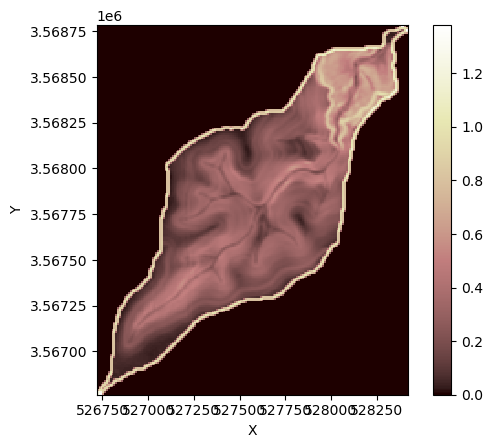

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun  9 18:22:27 2022
@author: sam, angel, and mikey

experiment for lc3, later lc1 will be added, and then will become a jupyterhub
notebook tutorial for the new river bed dynamics component

"""

""" 
Here we imporant all necessary components and other stuff
"""

import numpy as np
import pandas as pd
import copy
import os
import shutil
from matplotlib import pyplot as plt
from landlab.components import OverlandFlowSpatiallyVariableInputs, RiverBedDynamics, SinkFiller, FlowAccumulator
from landlab.io import read_esri_ascii
from landlab import imshow_grid
from landlab.components import DepressionFinderAndRouter
#from landlab import RasterModelGrid as mg
from landlab.components import ChannelProfiler


"""
First we import the DEM. There are two DEMS called:
    lc3_dem.txt
    and lc1_dem.txt
    
We then generate a slope map to make sure the DEM was properly imported
"""

watershed_dem = 'DEMs/lc3_dem.txt' 
(rmg, z) = read_esri_ascii(watershed_dem, name='topographic__elevation')

rmg.at_node['topographic__slope'] = rmg.calc_slope_at_node(elevs='topographic__elevation')
imshow_grid(rmg,'topographic__slope');
plt.show()



In [2]:

rmg.set_watershed_boundary_condition(z,nodata_value=-9999.)
sf = SinkFiller(rmg, routing='D4', apply_slope=True, fill_slope=1.e-5)
sf.fill_pits()


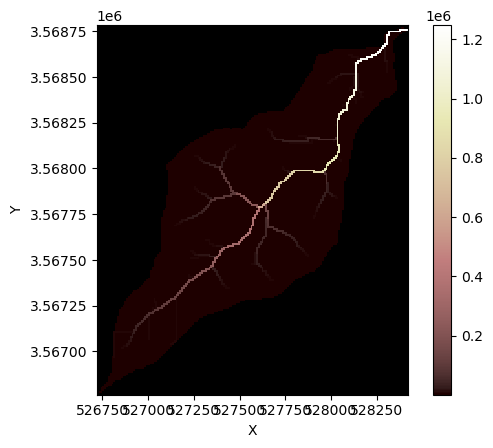

"\nimshow_grid(rmg, '')\nplt.show()\n"

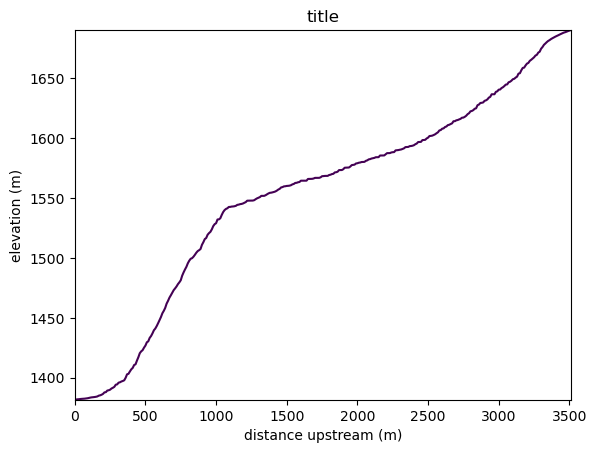

In [3]:
fa = FlowAccumulator(
     rmg,
     'topographic__elevation',
     flow_director='FlowDirectorSteepest',
     depression_finder=DepressionFinderAndRouter,
     routing='D4'
)

fa.run_one_step()

imshow_grid(rmg, 'drainage_area')
plt.show()



profiler = ChannelProfiler(
    rmg,
    number_of_watersheds=1,
    minimum_channel_threshold=0,
    main_channel_only= True)

profiler.run_one_step()



profiler.plot_profiles(
    xlabel="distance upstream (m)", ylabel="elevation (m)", title='title'
)




'''
imshow_grid(rmg, '')
plt.show()
'''

In [ ]:
"""
Second, I explain grain sizes. They live in the '/GSDs' folder. Any user can go
take a look at them. As this project moves formward, I will find a place to
put the "raw" grain size data, but for now the data is presented in a way that
this code can understand. 

There are a few different excels in the grain size folder. Note to self: Eventually 
some of these comments will be readmes or some folder explanation or whatever. 
Anyways, there are 3 excels which represent real GSDs and were measured with 
drone photos. 

Column 0, in the LC3 gsd file, are b axis diameters for the 'shallow' channel 
section (above 1560m elevation), 1 are diameters for 1530m - 1560m elevation,
and 2 are diameters for steep elevations lower than 1530. 

For LC1 column 0 are diameters for elevations above 1560 m, column 1 are diameters
for elevations 1540 - 1560m, and column 2 are grain size diameters in elevations
lower than 1540 m in elevation.
    
The corresponding GSD info for LC1 is...
    LC1_grain_size_dist.xlsx
    and LC1_gsd_locations.txt
    
...and for LC3 is 
    LC3_grain_size_dist.xlsx
    and LC3_gsd_locations.txt   
    NOTE: LC3 has two gsds, one has more information (it's broken down into smaller
    bins) this one is called LC3_grain_size_dist_higher_res.xlsx                                                
"""

gsd = pd.read_excel('GSDs/LC3_grain_size_dist_higher_res.xlsx', sheet_name='GSD', skiprows=0).values
bedGSDLocationRaster = 'GSDs/LC3_gsd_locations.txt'     
(rmg0, gsd_loc) = read_esri_ascii(bedGSDLocationRaster)
rmg['node']['bed_surface__grainSizeDistribution_location'] = gsd_loc 

"""
Here we have precip data
I have a folder called climate where all the different .xlsx files which 
control intensity and duration live. To call them use first the duration, in
minutes, and then the recurrence interval (RI) in years and then "storm". like so...

#duration_#yrRI_storm.xlsx

for example a 5 minute long storm with a 1 year RI would be experessed like so...

5min_1yrRI_storm.xlsx

The only things that need to be changed are the numbers (in this case 5 and 1), and
sometimes the duration units (min, hours, days)

The shortest storm is 5 minutes, the longest is yet to be determined, but will 
most likely be one day. The lowest RI is 1 and the highest is 1000. Feel free 
to open the climate folder to decide on a storm to run!
"""

rainfallFile = 'climate/5min_1000yrRI_storm.xlsx'
precipitation = pd.read_excel(rainfallFile)  
precip_time=precipitation.values[:,0]
precip_mmhr=precipitation.values[:,1]
precip_ms = precip_mmhr * (2.77778 * 10 ** -7)  # Converts mm/hr to m/s
precip_index = 0     

""" 
This is info regarding time, and plotting stuff, and Manning's n. The max possible time for 
all storms is 100000 seconds,although most storms will not need to be that long
Kinda seems like it takes around 10,000 seconds for water to completely drain
from LC3 for a 1000yr RI storm with a duration of one day. 
"""

dtPrecision = 3               # Avoids rounding errors
max_dt = 1                   # Overland flow will use the min time step between this value and the automatically calculated. Use seconds.
tPlot = 200                  # Plots will be obtained every this seconds
storeData = 5                 # Stores results every this time
tmax = 4000 + max_dt          # Maximum simulation time, adding max_dt ensures that the last time is stored
n = 0.03                      # Manning's n      

"""
Links and nodes where we will sample. For now I am going to choose 3 links and 
nodes in the middle of each section of LC3. maybe in the future I will 
"""
#UNDER CONSTRUCTION
"""
link_to_sample = 64912
node_to_sample = 32457
"""
# These are NOT 'real' links and nodes
link_to_sample = np.array([299, 698,1496,2694,32221])
node_to_sample = np.array([300,700,16102])

"""
This removes previous figs from the output folder. 
"""
directory = os.getcwd() ; test = os.listdir( directory )
for item in test:
    if item.endswith(".png"):
        os.remove( os.path.join( directory, item ) )
        
"""
Creates necessary fields. The roughness field iscurrently uniform.
"""
OverlandFlowSpatiallyVariableInputs.input_var_names
RiverBedDynamics.input_var_names
rmg.add_zeros('bed_surface__roughness', at = 'link')
rmg.add_zeros('surface_water__depth', at = 'node')
rmg.add_zeros('rainfall__intensity', at = 'node')
rmg['link']['bed_surface__roughness'] = np.zeros(rmg.number_of_links) + n
#rmg.add_zeros('surface_water__shearStress', at = 'link')


"""
Instatiates the two components, note that RiverBedDynamics can be changed to 
a model other than MPM 
"""
of = OverlandFlowSpatiallyVariableInputs(rmg, steep_slopes=True, alpha = 0.3)
rbd = RiverBedDynamics(rmg , gsd = gsd, variableCriticalShearStress = True, bedloadEq='WilcockAndCrowe')

""" 
This is under construction. As it stands, it works for LC3. Need to figure out LC1.

Update: I am gonna remake both 'sheds' using the 10m and the 1m DEM, and just use the auto way
"""
#rmg.set_watershed_boundary_condition_outlet_id([33999], z, nodata_value=-9999.) # This is LC3, works!
#rmg.set_watershed_boundary_condition_outlet_id((35680), z, nodata_value=-9999.) # This is LC1 (work in progress), out let is row 218, col 93

outlet = rmg.set_watershed_boundary_condition(z, remove_disconnected = True, nodata_value=-9999.00, return_outlet_id=True) 
print(outlet)



"""
Defines variables to store data and run the experiment. Also creates a folder
called /output where figures and data is stored. All figures are deleted from 
the folder after each model run.
"""

storeNow = True
plotNow = True                          # Used to save the plot at time zero
check_tmax = True
tPlotOrg=copy.deepcopy(tPlot)           # A copy of tPlot, for plotting purposes (i think)
storeDataOrg=copy.deepcopy(storeData)   # A copy of tPlot
outputFolder = 'output'
cwd = os.getcwd()

if os.path.exists(outputFolder):
    print('The folder') 
    print(outputFolder)
    print('Exists and it will be removed \n');
    shutil.rmtree(outputFolder)     
os.mkdir(outputFolder)

"""  
runs the experiment 
"""
hydrograph_time = []
hydrograph_time.append(precip_time / 3600.) # convert seconds to hours

t = 0
while t < tmax:
    
    rbd.t = t           # Current simulation time
    
    #Calculates the rainfall intensity - variable in time
    if (t >= precip_time[precip_index+1]):
        rmg['node']['rainfall__intensity'] =  np.zeros(rmg.number_of_nodes) + precip_ms[precip_index+1]
        precip_index += 1
    else:
        rmg['node']['rainfall__intensity'] = np.zeros(rmg.number_of_nodes) + precip_ms[precip_index+1]
    
    of.overland_flow()  # Runs overland flow for one time step
    rbd.run_one_step()  # Runs riverBedDynamics for one time step
    
    """
    Saves data of to 6 different txt files from link and node to sample specified earlier
    """
    
    profiler.run_one_step()
    profiler.plot_profiles(
            xlabel="distance upstream (m)", ylabel="elevation (m)", title='title'
        )



    
    
    storeData = round(storeData-of.dt, dtPrecision)
    if (storeData <=0) or storeNow:
        os.chdir(outputFolder)
        
        profiler.plot_profiles(
            xlabel="distance upstream (m)", ylabel="elevation (m)", title='title'
        )
        
        
        
        print('Storing results at time :',np.round(t,1),' s \n')
        data = np.hstack([t,(np.abs(of._q[link_to_sample] * rmg.dx).T)])
        with open("output0_links_surface_water__discharge.txt", "ab") as f:
            np.savetxt(f, data,'%.3f')
        data = np.hstack([t,(of._h[node_to_sample].T)])
        
        data = np.reshape(data,[1,data.shape[0]])

        with open("output1_node_surface_water__depth.txt", "ab") as f:
            np.savetxt(f, data,'%.3f')      
        data = np.hstack([t,np.abs(rbd._tau[link_to_sample].T)])
        
        data = np.reshape(data,[1,data.shape[0]])

        with open("output2_link_surface_water__shearStress.txt", "ab") as f:
            np.savetxt(f, data,'%.3f')   
        data = np.hstack([t,rmg.at_node["topographic__elevation"][node_to_sample].T])
        
        data = np.reshape(data,[1,data.shape[0]])

        with open("output3_node_topographic__elevation.txt", "ab") as f:
            np.savetxt(f, data,'%.3f') 
        data = np.hstack([t,rmg.at_link["bed_surface__medianSize"][link_to_sample].T])
        
        data = np.reshape(data,[1,data.shape[0]])

        with open("output4_link_bed_surface__medianSize.txt", "ab") as f:
            np.savetxt(f, data,'%.3f')
        data = np.hstack([t,rmg.at_link['sediment_transport__bedloadRate'][link_to_sample].T])
        
        data = np.reshape(data,[1,data.shape[0]])

        with open("output5_links_sediment_transport__bedloadRate.txt", "ab") as f:
            np.savetxt(f, data,'%.5f')  
        storeData = round(storeDataOrg, dtPrecision)
        storeNow = False
        os.chdir(cwd)

    tPlot = round(tPlot-of.dt, dtPrecision)
    if tPlot <= 0  or plotNow:
        os.chdir(outputFolder)
        print('Elapsed time :',np.round(t,1),' s. Current dt =',\
              np.round(of.dt,1),'. Adaptive time =',np.round(of._adaptive_dt,1),' s - Saving plot \n')
       

        """
        Here we generate plots
        """
        # Water depth plot
        plot_name='Surface water depth [m] at ' + str(np.round(t,0)) + ' sec'
        imshow_grid(rmg, 'surface_water__depth',cmap='Blues',vmin=0, vmax=1, plot_name=plot_name)
        output='depth_'+str(np.round(t,0))+'.png'
        plt.savefig(output,dpi=300); plt.close()  
        
        #Bed surface elevation plot
        plot_name='Bed surface elevation [m] at ' + str(np.round(t,0)) + ' sec'
        ZBed = rmg.at_node["topographic__elevation"]
        imshow_grid(rmg, ZBed ,cmap='RdGy',plot_name=plot_name)
        output='topographicElevation_'+str(np.round(t,0))+'.png'
        plt.savefig(output,dpi=300); plt.close()  
        
        #Bed surface variation plot
        plot_name='Bed surface elevation variation [m] at ' + str(np.round(t,0)) + ' sec' 
        ZVar = rmg.at_node["topographic__elevation"] - rmg.at_node['topographic__elevation_original'] 
        imshow_grid(rmg, ZVar,cmap='RdGy',plot_name=plot_name)
        output='topographicVariation_'+str(np.round(t,0))+'.png'
        plt.savefig(output,dpi=300); plt.close()  
        
        """ UNDER CONSTRUCTION: NEED TO MAP LINKS TO NODES- HOW?
        #Shear stress map - not sure I need this? you gon
        plot_name='Shear stress [Pa] at ' + str(np.round(t,0)) + ' sec' 
        
        Zstress = rmg.at_link["surface_water__shearStress"]
        q=Zstress
        mg.map_link_vector_to_nodes(q)
        
        imshow_grid(rmg, Zstress, cmap='RdGy',plot_name=plot_name)
        output='shearStress_'+str(np.round(t,0))+'.png'
        plt.savefig(output,dpi=300); plt.close()    
        """


        plotNow = False
        tPlot = tPlotOrg
        os.chdir(cwd)

    # Updating t
    if (t + of.dt > tmax) and check_tmax:
        of.dt = tmax - t
        t = tmax
        storeDataNow = True  
        plotNow = True
        check_tmax = False
    else:
        t = round(t + of.dt, dtPrecision)  
"""        
nodes and links figs UNDER CONSTRUCTION     
COME BACK TO THIS

#1) I think first we find storm charictoristics like when during a storm "work" happens.
    so here we track a few storms of different intensities and durations and when erosion happens
    at 6 different cells (1 from each channel section)
    OR maybe more then 1 cell in each "section"? How will i choose cells?
   
    Storm Duration on x axis vs a. topographic variation, b. bedload rate, and c. dischage 
    for 4 different models and maaaybe high and low res DEM
  """  
  
data = np.loadtxt('output/output1_node_surface_water__depth.txt')
nodesToSample = np.arange(rmg.number_of_node_columns+1,2*rmg.number_of_node_columns)
x = np.arange(0,(rmg.number_of_node_columns-1)*rmg.dx,rmg.dx)

hSample = data[-1, nodesToSample]

plt.figure(1)
plt.plot(x, hSample, color='red', label='Our Model')
plt.legend()
plt.ylabel('Water depth (m)')
plt.xlabel('x (x)')
plt.ylim(0,2.5)
plt.xlim(0,3700)
plt.title('Water depth at 3600 s')


[33999]
The folder
output
Exists and it will be removed 

Storing results at time : 0  s 

Elapsed time : 0  s. Current dt = 10.0 . Adaptive time = 302.9  s - Saving plot 

Storing results at time : 10.0  s 

Storing results at time : 20.0  s 

Storing results at time : 30.0  s 

Storing results at time : 40.0  s 

Storing results at time : 49.9  s 

Storing results at time : 58.1  s 

Storing results at time : 65.1  s 

Storing results at time : 71.3  s 

Storing results at time : 76.8  s 

Storing results at time : 86.4  s 

Storing results at time : 94.6  s 

Storing results at time : 101.7  s 

Storing results at time : 108.1  s 

Storing results at time : 113.8  s 

Storing results at time : 121.5  s 

Storing results at time : 128.4  s 

Storing results at time : 134.6  s 

Storing results at time : 140.4  s 

Storing results at time : 145.8  s 

Storing results at time : 152.5  s 

Storing results at time : 158.7  s 

Storing results at time : 164.6  s 

Storing results at time 

Storing results at time : 1136.4  s 

Storing results at time : 1141.6  s 

Storing results at time : 1146.8  s 

Storing results at time : 1151.9  s 

Storing results at time : 1157.1  s 

Storing results at time : 1162.2  s 

Storing results at time : 1167.3  s 

Storing results at time : 1172.4  s 

Storing results at time : 1177.5  s 

Storing results at time : 1182.6  s 

Storing results at time : 1187.7  s 

Storing results at time : 1192.7  s 

Storing results at time : 1197.8  s 

Storing results at time : 1202.8  s 

Storing results at time : 1207.8  s 

Elapsed time : 1211.9  s. Current dt = 0.3 . Adaptive time = 0.3  s - Saving plot 

Storing results at time : 1212.8  s 

Storing results at time : 1218.1  s 

Storing results at time : 1223.4  s 

Storing results at time : 1228.7  s 

Storing results at time : 1234.0  s 

Storing results at time : 1239.2  s 

Storing results at time : 1244.5  s 

Storing results at time : 1249.7  s 

Storing results at time : 1255.0  s 

Stor

Storing results at time : 2190.9  s 

Storing results at time : 2196.0  s 

Storing results at time : 2201.1  s 

Storing results at time : 2206.3  s 

Storing results at time : 2211.4  s 

Elapsed time : 2213.1  s. Current dt = 0.3 . Adaptive time = 0.3  s - Saving plot 

Storing results at time : 2216.5  s 

Storing results at time : 2221.6  s 

Storing results at time : 2226.7  s 

Storing results at time : 2231.8  s 

Storing results at time : 2236.9  s 

Storing results at time : 2242.1  s 

Storing results at time : 2247.2  s 

Storing results at time : 2252.3  s 

Storing results at time : 2257.4  s 

Storing results at time : 2262.6  s 

Storing results at time : 2267.7  s 

Storing results at time : 2272.8  s 

Storing results at time : 2278.0  s 

Storing results at time : 2283.1  s 

Storing results at time : 2288.2  s 

Storing results at time : 2293.4  s 

Storing results at time : 2298.5  s 

Storing results at time : 2303.6  s 

Storing results at time : 2308.7  s 

Stor

In [ ]:
profiler.plot_profiles(
        xlabel="distance upstream (m)", ylabel="elevation (m)", title='title'
    )

